#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩
    - pandas, numpy,matplotlib,seaborn, joblib 을 로딩하고
    필요한 라이브러리를 로딩합니다.
    <br>(분류 모델에서는 이번에 RandomForestClassifier를 씁니다. 더 많은 분류 모델을 써도 됩니다!)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns)
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [4]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [8]:
# 주어진 데이터 셋을 불러오세요.
train_data_set = pd.read_csv("data01_train.csv")
test_data_set = pd.read_csv("data01_test.csv")

In [10]:
#불필요한 칼럼을 삭제하세요.
train_data_set.drop("subject", axis=1)
test_data_set.drop("subject", axis=1)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466,0.278725,-0.015262,-0.106398,-0.993625,-0.982845,-0.974745,-0.993963,-0.981100,-0.974596,-0.939303,...,-0.586580,-0.874066,-0.054788,0.712975,0.300318,-0.319188,-0.857336,0.120184,0.119276,SITTING
1467,0.275803,-0.019257,-0.109078,-0.998614,-0.991621,-0.987403,-0.998813,-0.991503,-0.986802,-0.945442,...,-0.451941,-0.721050,0.076333,-0.021599,-0.277268,0.754011,-0.764185,0.212111,0.138595,STANDING
1468,0.240402,0.006361,-0.121377,-0.045805,0.189930,0.332664,-0.114706,0.157771,0.195271,0.210139,...,-0.213340,-0.615554,0.330378,-0.667635,0.806563,-0.850113,-0.639564,0.185363,0.260201,WALKING_DOWNSTAIRS
1469,0.135873,-0.020675,-0.116644,-0.960526,-0.955134,-0.985818,-0.963115,-0.971338,-0.988261,-0.946289,...,0.072602,-0.422383,-0.048474,0.236761,-0.186581,0.396648,0.790877,-0.474618,-0.505953,LAYING


## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [29]:
# 전체 데이터의 행, 열 개수를 확인
print("train 데이터프레임 크기 : ", train_data_set.shape)
print("test 데이터프레임 크기 : ", test_data_set.shape)

train 데이터프레임 크기 :  (5881, 563)
test 데이터프레임 크기 :  (1471, 563)


In [18]:
# 전체 데이터의 상위 5개 행 확인
train_data_set.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS


In [22]:
# 전체 데이터의 수치형 변수 분포 확인
test_data_set.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,...,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000
mean,0.273198,-0.017281,-0.108123,-0.614634,-0.515427,-0.607533,-0.639950,-0.530760,-0.609256,-0.481055,...,-0.311513,-0.632273,0.009324,0.015666,0.006272,-0.001510,-0.481737,0.055771,-0.064194,17.539089
std,0.079989,0.045957,0.049082,0.448480,0.506094,0.424243,0.422994,0.489381,0.418536,0.542756,...,0.313792,0.296179,0.324864,0.452616,0.608954,0.483028,0.522714,0.298124,0.281645,9.122876
min,-1.000000,-1.000000,-0.418354,-0.999717,-0.999873,-1.000000,-0.999867,-1.000000,-0.999879,-0.948723,...,-0.995357,-0.994664,-0.937468,-0.990492,-0.995222,-0.969066,-0.999380,-0.995073,-1.000000,1.000000
25%,0.263787,-0.024792,-0.120733,-0.992669,-0.979082,-0.981070,-0.993498,-0.979214,-0.980659,-0.936791,...,-0.546342,-0.844547,-0.119166,-0.265533,-0.485998,-0.380300,-0.814060,-0.017413,-0.148445,8.000000
50%,0.277322,-0.017187,-0.108124,-0.952426,-0.867309,-0.869890,-0.958705,-0.873891,-0.863451,-0.890491,...,-0.347433,-0.706699,0.005049,0.023421,-0.005036,0.002408,-0.708911,0.178814,-0.002243,19.000000
75%,0.288058,-0.010238,-0.096606,-0.245405,-0.030639,-0.260223,-0.297260,-0.058824,-0.256657,-0.030692,...,-0.125796,-0.516910,0.135698,0.312690,0.518184,0.374583,-0.486534,0.248126,0.096674,26.000000
max,0.631510,0.359587,0.543939,0.899922,0.782590,0.931308,0.950758,0.602458,0.784041,0.821218,...,0.941113,0.894210,0.980889,0.991899,0.994366,0.979522,1.000000,0.432496,0.992766,30.000000


In [33]:
#전체 데이터의 모든 변수 확인
test_data_set.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'subject', 'Activity'],
      dtype='object', length=563)

In [ ]:
#(추가) 다양하게 기본 정보들을 확인하세요!

### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [36]:
# Activity 에 대해서 단변량 분석을 시행합니다. (범주별 빈도수, 종류, 비율, 시각화도 해보기!)
train_data_set['Activity'].value_counts()

,count
Activity,
LAYING,1115
STANDING,1087
SITTING,1032
WALKING,998
WALKING_UPSTAIRS,858
WALKING_DOWNSTAIRS,791


<Axes: xlabel='count', ylabel='Activity'>

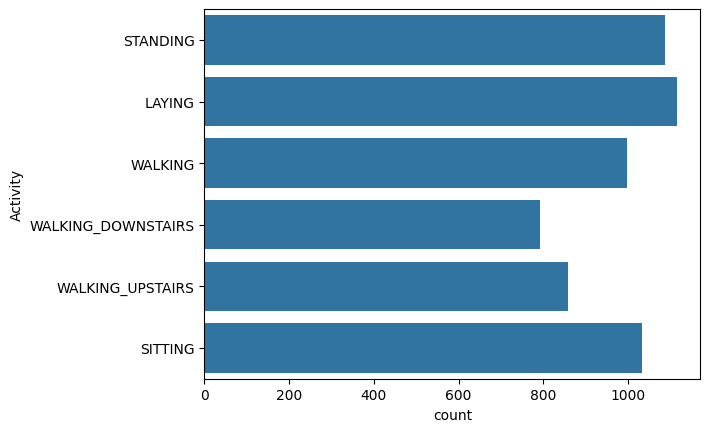

In [40]:
sns.countplot(train_data_set['Activity'])

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [42]:
features = pd.read_csv("features.csv")

In [50]:
#센서 그룹 데이터의 'sensor'변수의 값 확인
features['sensor'].value_counts()

,count
sensor,
fBodyGyro,79
fBodyAccJerk,79
fBodyAcc,79
tBodyAcc,40
tGravityAcc,40
tBodyAccJerk,40
tBodyGyroJerk,40
tBodyGyro,40
tGravityAccMag,13


In [51]:
#센서 그룹 데이터의 'agg'변수의 값 확인
features['agg'].value_counts()

,count
agg,
bandsEnergy(),126
arCoeff(),60
std(),33
mad(),33
max(),33
energy(),33
min(),33
entropy(),33
iqr(),33


In [52]:
#센서 그룹 데이터의 'axis'변수의 값 확인
features['axis'].value_counts()

,count
axis,
X,76
Y,76
Z,76
gravityMean,6
"X,2",5
...,...
"17,32.2",2
"49,64.2",2
"1,24.2",2


## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [53]:
from sklearn.model_selection import train_test_split

In [134]:
# 데이터 분할을 위한 전처리
x = train_data_set.drop(columns=['Activity','is_dynamic'], axis = 1)
y = train_data_set['Activity']
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3)

#### 2) 모델링

,feature_name,feature_importance
0,tGravityAcc-energy()-X,0.035848
1,"angle(X,gravityMean)",0.034667
2,tGravityAcc-mean()-X,0.031935
3,tGravityAcc-max()-Y,0.029931
4,tGravityAcc-max()-X,0.028881


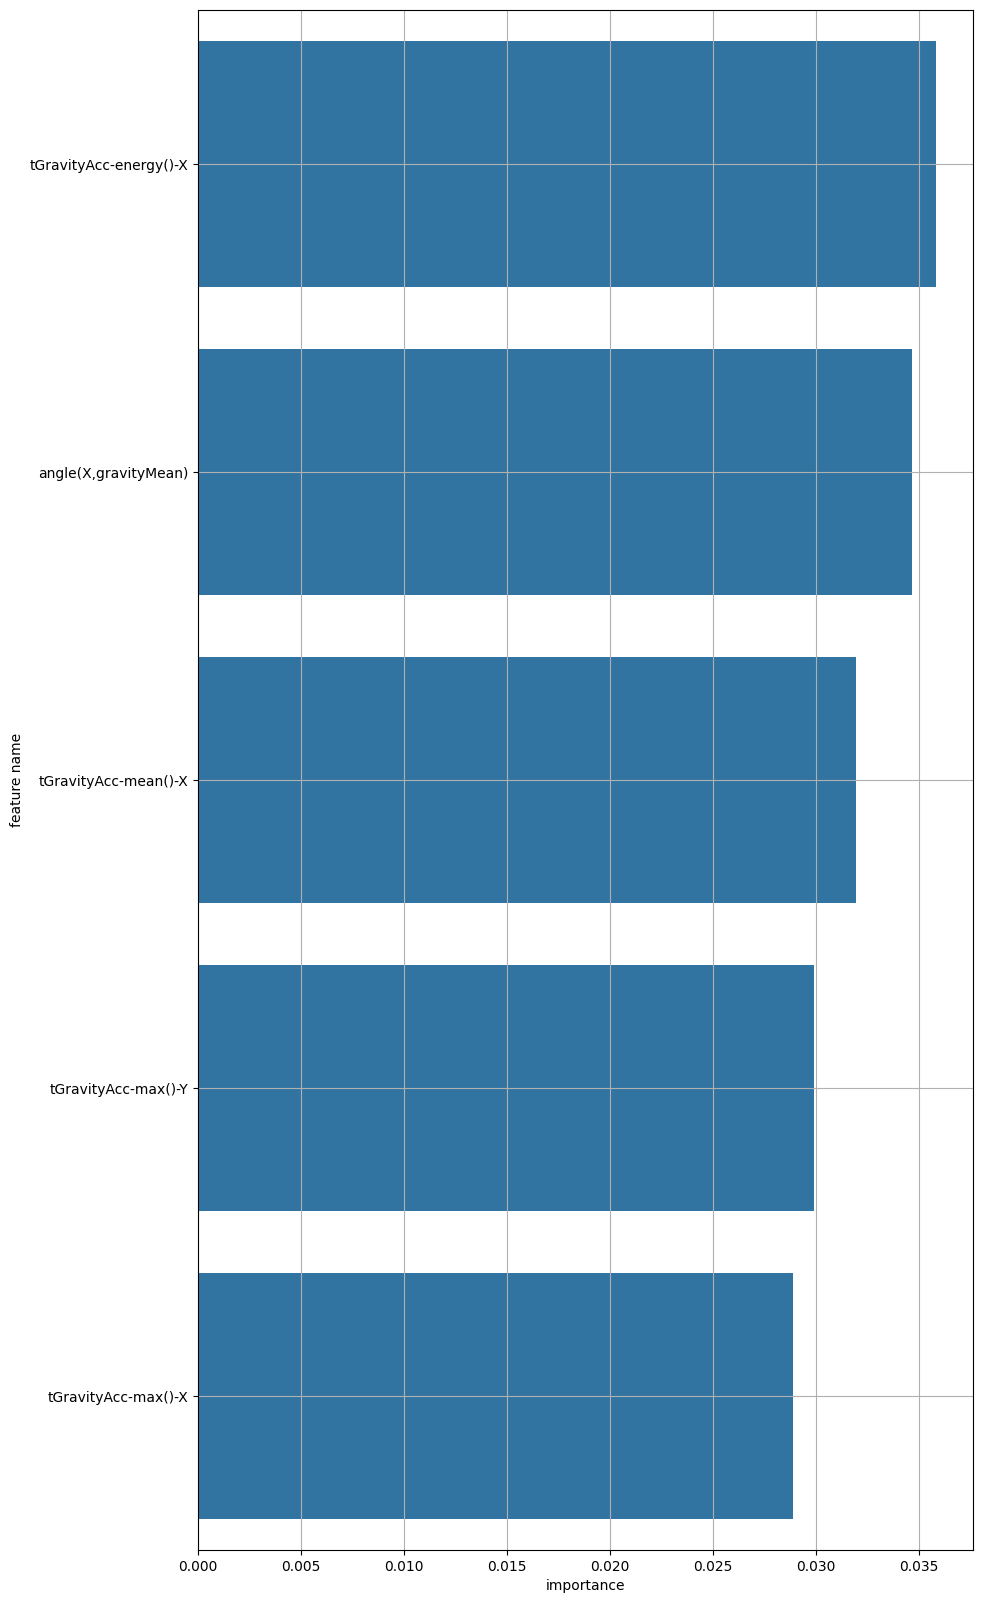

In [135]:
#생성
model = RandomForestClassifier()
#학습
model.fit(x_train, y_train)
#평가
plot_feature_importance(model.feature_importances_, x.columns, False, 5)

In [136]:

#평가
plot_feature_importance(model.feature_importances_, x.columns, True)

,feature_name,feature_importance
0,tGravityAcc-energy()-X,0.035848
1,"angle(X,gravityMean)",0.034667
2,tGravityAcc-mean()-X,0.031935
3,tGravityAcc-max()-Y,0.029931
4,tGravityAcc-max()-X,0.028881
...,...,...
557,"fBodyAcc-bandsEnergy()-25,32.1",0.000079
558,fBodyAccJerk-min()-X,0.000077
559,"fBodyAcc-bandsEnergy()-33,48.1",0.000058
560,"fBodyAccJerk-bandsEnergy()-25,48.1",0.000055


#### 3) 변수 중요도 추출

In [137]:
result1 = plot_feature_importance(model.feature_importances_, names=x.columns, result_only=True,)
result1

,feature_name,feature_importance
0,tGravityAcc-energy()-X,0.035848
1,"angle(X,gravityMean)",0.034667
2,tGravityAcc-mean()-X,0.031935
3,tGravityAcc-max()-Y,0.029931
4,tGravityAcc-max()-X,0.028881
...,...,...
557,"fBodyAcc-bandsEnergy()-25,32.1",0.000079
558,fBodyAccJerk-min()-X,0.000077
559,"fBodyAcc-bandsEnergy()-33,48.1",0.000058
560,"fBodyAccJerk-bandsEnergy()-25,48.1",0.000055


In [138]:
# 그룹화
result1['group'] = result1['feature_name'].str.split('-').str[0].str.split('(').str[0]
grouped1 = result1.groupby('group')['feature_importance'].sum().reset_index()
grouped1 = grouped1.sort_values(by='feature_importance', ascending=False).reset_index(drop=True)
grouped1

,group,feature_importance
0,tGravityAcc,0.337061
1,fBodyAccJerk,0.122051
2,fBodyAcc,0.073591
3,angle,0.070923
4,tBodyAccJerk,0.063302
5,fBodyGyro,0.061675
6,tBodyAcc,0.048004
7,fBodyAccMag,0.042449
8,tBodyGyro,0.036193
9,tBodyGyroJerk,0.035976


<Axes: xlabel='feature_importance', ylabel='group'>

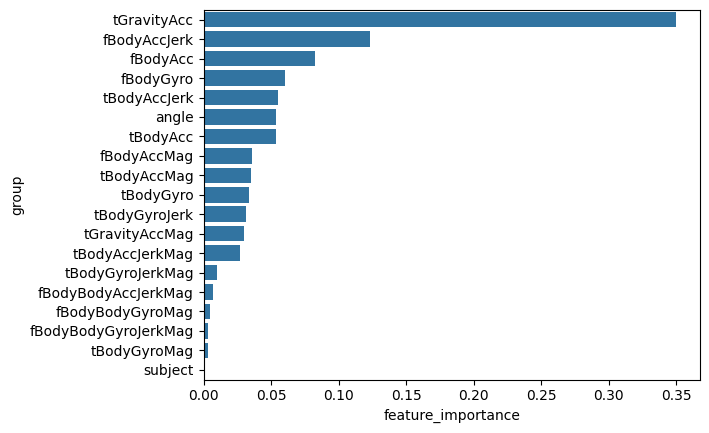

In [101]:
# 변수 중요도 추출(시각화로 나타내기)
sns.barplot(x='feature_importance', y='group', data=grouped1[:])

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [124]:
# 중요도 상위 top 5
best = grouped1.head(5)
best

,group,feature_importance
0,tGravityAcc,0.336861
1,fBodyAccJerk,0.090706
2,fBodyAcc,0.089031
3,fBodyGyro,0.074759
4,angle,0.073836


In [103]:
# 중요도 하위 top 5
worst = grouped1.tail(5)
worst

,group,feature_importance
14,fBodyBodyAccJerkMag,0.006590
15,fBodyBodyGyroMag,0.005022
16,fBodyBodyGyroJerkMag,0.003567
17,tBodyGyroMag,0.003119
18,subject,0.000407


#### 2) 상위 5개 변수에 대한 분석
        - 위에서 나온 상위 5개의 변수를 선정해서 target과의 관계를 kdeplot으로 그려보세요!

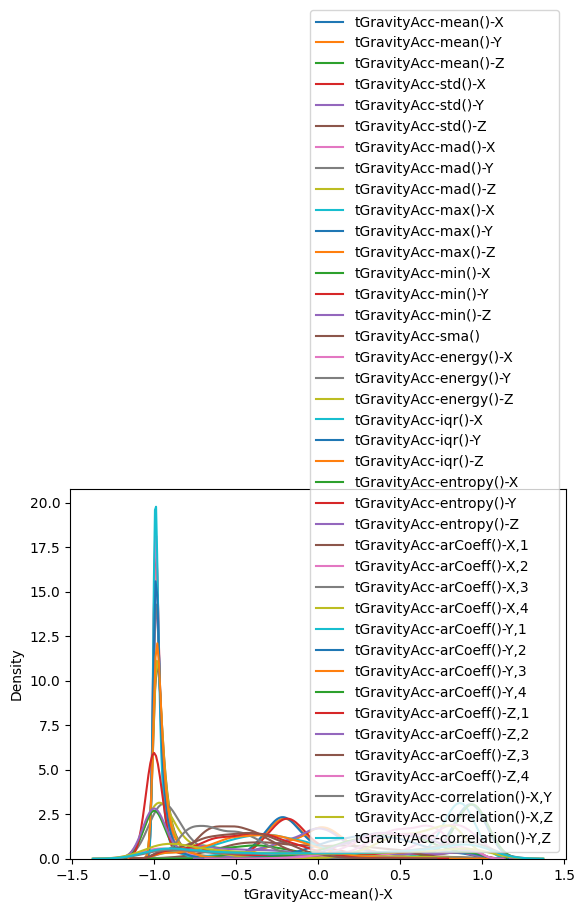

In [109]:
# 1위 : tGravityAcc

for col in train_data_set.filter(regex='^tGravityAcc-') :
  sns.kdeplot(train_data_set[col], label=col)

plt.legend()
plt.show()

In [ ]:
# 2위: fBodyAccJerk

In [ ]:
# 3위: fBodyAcc

In [ ]:
# 4위: fBodyGyro

In [ ]:
# 5위: tBodyAccJerk

#### 3) 하위 5개 변수에 대한 분석
        - 위에서 하위 5개의 변수를 선정해서 target과의 관계를 kdeplot으로 그려보세요!

In [ ]:
#1위 : oooo

In [ ]:
#2위: vvvvv

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.


#### 1) is_dynamic 추가

In [110]:
#is dynamic 변수를 추가하세요(값 0, 값 1 확인해서!)
dynamic_activities = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']
train_data_set['is_dynamic'] = train_data_set['Activity'].apply(lambda x: 1 if x in dynamic_activities else 0)

In [111]:
train_data_set

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,21,SITTING,0
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,15,WALKING_UPSTAIRS,1
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,19,LAYING,0
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,6,WALKING_UPSTAIRS,1


#### 2) 기본모델 생성

In [125]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
x_train, x_val, y_train, y_val = train_test_split(train_data_set.drop(columns=['Activity', 'is_dynamic']), train_data_set['is_dynamic'], train_size=0.75)

,feature_name,feature_importance
0,fBodyAccJerk-std()-X,0.069881
1,fBodyAccJerk-max()-X,0.059972
2,tBodyGyroJerk-iqr()-Z,0.059834
3,"fBodyAccJerk-bandsEnergy()-1,8",0.050222
4,tBodyAccJerk-mad()-X,0.040055


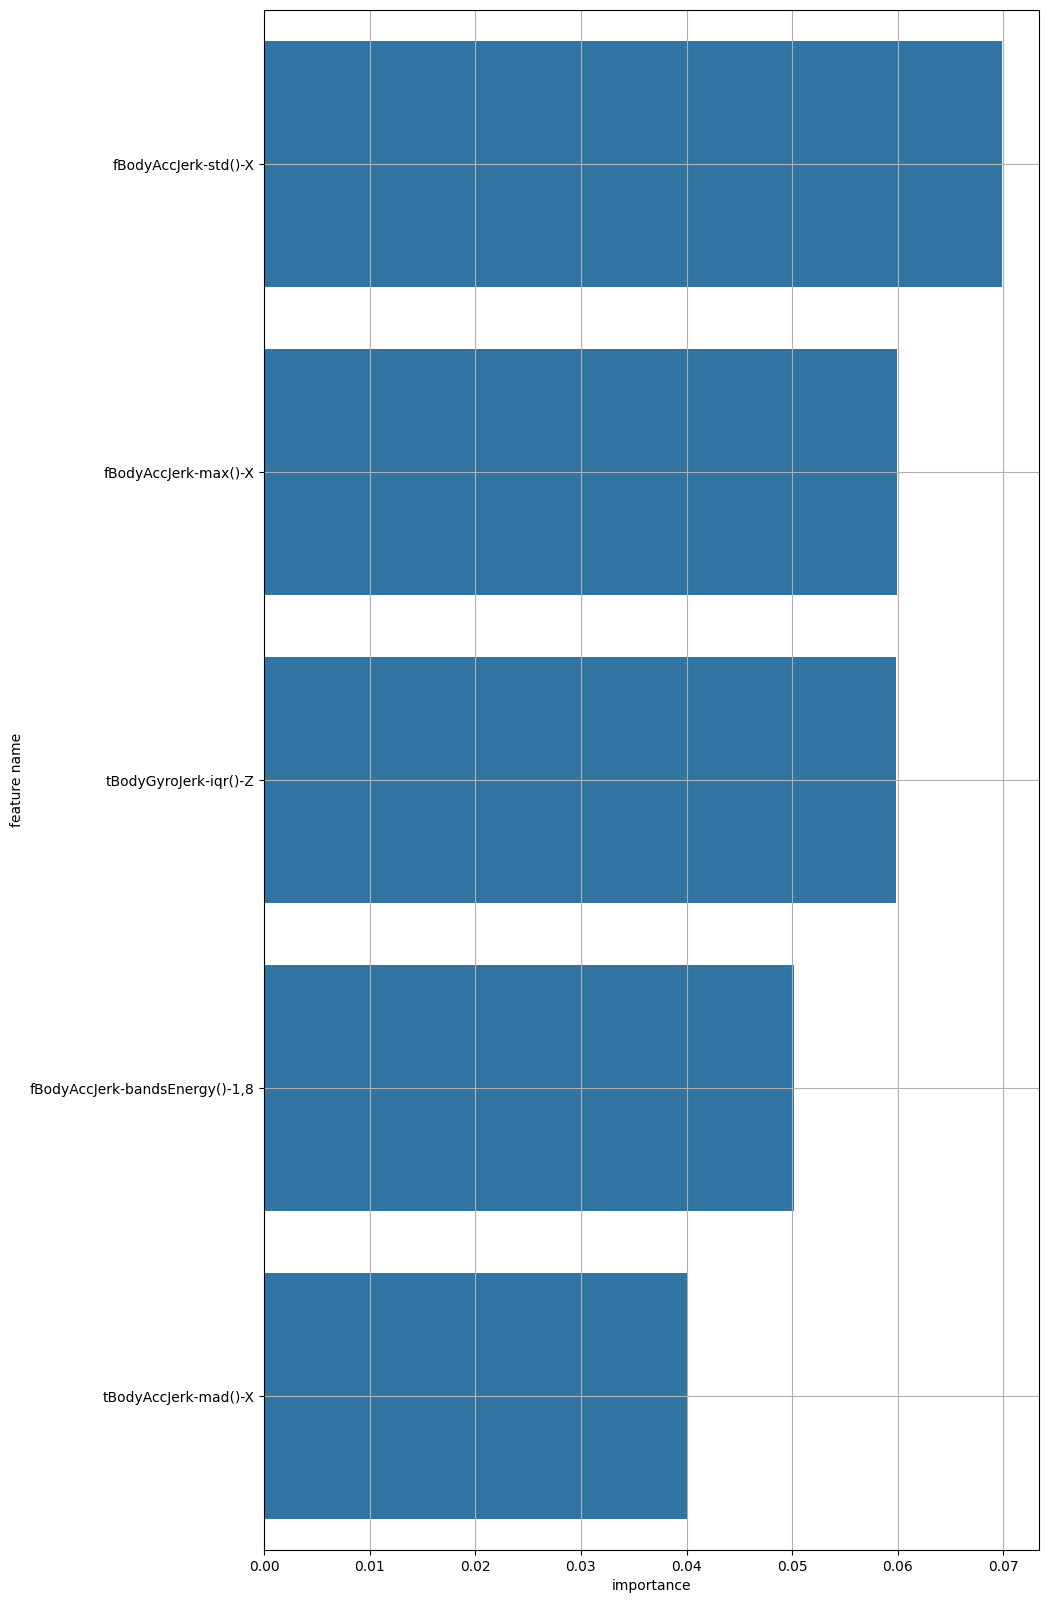

In [126]:
#RandomForestClassifier로 모델링 진행
model = RandomForestClassifier()
model.fit(x_train, y_train)
plot_feature_importance(model.feature_importances_, train_data_set.drop(columns=['Activity', 'is_dynamic']).columns, False, 5)


#### 3) 변수중요도 상위 5개 분석

In [127]:
# 그룹화
result2 = plot_feature_importance(model.feature_importances_, train_data_set.drop(columns=['Activity', 'is_dynamic']).columns, True)
result2['group'] = result2['feature_name'].str.split('-').str[0].str.split('(').str[0]
grouped2 = result2.groupby('group')['feature_importance'].sum().reset_index()
grouped2 = grouped2.sort_values(by='feature_importance', ascending=False).reset_index(drop=True)
grouped2

,group,feature_importance
0,fBodyAccJerk,0.389796
1,tBodyAccJerk,0.219535
2,tBodyGyroJerk,0.119709
3,tBodyAccJerkMag,0.089852
4,fBodyAcc,0.070046
5,tBodyAcc,0.030110
6,tBodyGyroJerkMag,0.029853
7,fBodyBodyAccJerkMag,0.019738
8,tBodyGyroMag,0.019636
9,tBodyGyro,0.010103


In [117]:
# is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석!
grouped2.head(5)

,group,feature_importance
0,fBodyAccJerk,0.429166
1,tBodyAccJerk,0.209785
2,tBodyAccJerkMag,0.099880
3,fBodyAcc,0.089549
4,tBodyGyroJerk,0.079335


* 미션1에서 했던 것 처럼 상위 5개의 변수 데이터를 탐색해보기!

In [ ]:
#1위:

In [ ]:
#2위:

## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

#### 1) 이름변경

In [130]:
features

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y
...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)"
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)"
558,angle,X,gravityMean,"angle(X,gravityMean)"
559,angle,Y,gravityMean,"angle(Y,gravityMean)"


In [139]:
grouped1

,group,feature_importance
0,tGravityAcc,0.337061
1,fBodyAccJerk,0.122051
2,fBodyAcc,0.073591
3,angle,0.070923
4,tBodyAccJerk,0.063302
5,fBodyGyro,0.061675
6,tBodyAcc,0.048004
7,fBodyAccMag,0.042449
8,tBodyGyro,0.036193
9,tBodyGyroJerk,0.035976


In [132]:
grouped2

,group,feature_importance
0,fBodyAccJerk,0.389796
1,tBodyAccJerk,0.219535
2,tBodyGyroJerk,0.119709
3,tBodyAccJerkMag,0.089852
4,fBodyAcc,0.070046
5,tBodyAcc,0.030110
6,tBodyGyroJerkMag,0.029853
7,fBodyBodyAccJerkMag,0.019738
8,tBodyGyroMag,0.019636
9,tBodyGyro,0.010103


from matplotlib import pyplot as plt
grouped2['feature_importance'].plot(kind='hist', bins=20, title='feature_importance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
grouped2['feature_importance'].plot(kind='line', figsize=(8, 4), title='feature_importance')
plt.gca().spines[['top', 'right']].set_visible(False)

In [140]:
# tip : rename을 써서 칼럼 이름 수정을 해야합니다!
grouped1.rename(columns={
    'feature_importance': 'feature_importance_activity',
})
grouped2.rename(columns={
    'feature_importance': 'feature_importance_is_dynamic'
})

,group,feature_importance_is_dynamic
0,fBodyAccJerk,0.389796
1,tBodyAccJerk,0.219535
2,tBodyGyroJerk,0.119709
3,tBodyAccJerkMag,0.089852
4,fBodyAcc,0.070046
5,tBodyAcc,0.030110
6,tBodyGyroJerkMag,0.029853
7,fBodyBodyAccJerkMag,0.019738
8,tBodyGyroMag,0.019636
9,tBodyGyro,0.010103


#### 2) 합치기

In [141]:
# merge 해서 2개를 합치는 작업하기
merged = pd.merge(grouped1, grouped2, on='group')

In [143]:
merged

,group,feature_importance_x,feature_importance_y
0,tGravityAcc,0.337061,0.001063
1,fBodyAccJerk,0.122051,0.389796
2,fBodyAcc,0.073591,0.070046
3,angle,0.070923,0.000046
4,tBodyAccJerk,0.063302,0.219535
5,fBodyGyro,0.061675,0.000234
6,tBodyAcc,0.048004,0.030110
7,fBodyAccMag,0.042449,0.000134
8,tBodyGyro,0.036193,0.010103
9,tBodyGyroJerk,0.035976,0.119709


### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [144]:
# joblib.dump 이용해서 colab에 .pkl 파일에 저장하기(tip: path + '파일 이름.pkl')
joblib.dump(merged, '/content/merged_importance.pkl')

['/content/merged_importance.pkl']

#### 고생하셨습니다! 이제 기본 모델링을 해봅시다.